# Import libs

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load data

In [2]:
df_user = pd.read_csv('../../Dataset/Tmall-Repeat-Buyer/user_info_format1.csv')
df_log = pd.read_csv('../../Dataset/Tmall-Repeat-Buyer/user_log_format1.csv')
df_train = pd.read_csv('../../Dataset/Tmall-Repeat-Buyer/train_format1.csv')
df_test = pd.read_csv('../../Dataset/Tmall-Repeat-Buyer/test_format1.csv')

# Show first 5 items of each data frame

In [3]:
df_train.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [4]:
df_test.head()

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


In [5]:
df_user.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [6]:
df_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


# Check info data

In [7]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  421953 non-null  float64
 2   gender     417734 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB


In [8]:
print(df_user[df_user["age_range"]==0].shape[0])
print(df_user[df_user["age_range"].isnull()].shape[0])
print(df_user[df_user["gender"]==2].shape[0])
print(df_user[df_user["gender"].isnull()].shape[0])

92914
2217
10426
6436


# Relpace invalid data with nan and check again

In [9]:
df_user["age_range"].replace(0.0, np.nan, inplace=True)
df_user["gender"].replace(2.0, np.nan, inplace=True)

In [10]:
print(df_user[df_user["age_range"]==0].shape[0])
print(df_user[df_user["age_range"].isnull()].shape[0])
print(df_user[df_user["gender"]==2].shape[0])
print(df_user[df_user["gender"].isnull()].shape[0])

0
95131
0
16862


# Check log data

In [11]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   seller_id    int64  
 4   brand_id     float64
 5   time_stamp   int64  
 6   action_type  int64  
dtypes: float64(1), int64(6)
memory usage: 2.9 GB


In [12]:
print(df_log[df_log["user_id"].isnull()].shape[0])
print(df_log[df_log["item_id"].isnull()].shape[0])
print(df_log[df_log["cat_id"].isnull()].shape[0])
print(df_log[df_log["seller_id"].isnull()].shape[0])
print(df_log[df_log["brand_id"].isnull()].shape[0])
print(df_log[df_log["time_stamp"].isnull()].shape[0])
print(df_log[df_log["action_type"].isnull()].shape[0])

0
0
0
0
91015
0
0


## Visualize time_stamp and action_type

<AxesSubplot:>

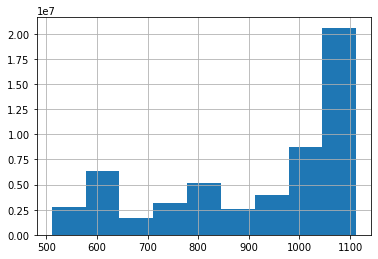

In [13]:
df_log["time_stamp"].hist(bins=9)

<AxesSubplot:>

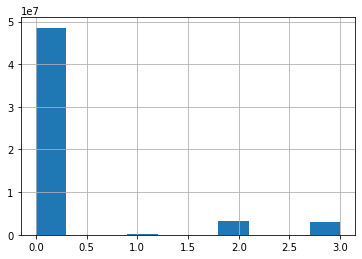

In [14]:
df_log["action_type"].hist()

# Extract features

## Merge age and gender

In [15]:
new_df_train = pd.merge(df_train,df_user,on="user_id",how="left")
new_df_train.head()

,user_id,merchant_id,label,age_range,gender
0,34176,3906,0,6.0,0.0
1,34176,121,0,6.0,0.0
2,34176,4356,1,6.0,0.0
3,34176,2217,0,6.0,0.0
4,230784,4818,0,NaN,0.0


## Merge views

In [16]:
total_views = df_log.groupby([df_log["user_id"],df_log["seller_id"]]).count().reset_index()[["user_id","seller_id","item_id"]]
total_views.rename(columns={"seller_id":"merchant_id","item_id":"total_views"},inplace=True)
new_df_train = pd.merge(new_df_train,total_views,on=["user_id","merchant_id"],how="left")
new_df_train.head()

,user_id,merchant_id,label,age_range,gender,total_views
0,34176,3906,0,6.0,0.0,39
1,34176,121,0,6.0,0.0,14
2,34176,4356,1,6.0,0.0,18
3,34176,2217,0,6.0,0.0,2
4,230784,4818,0,NaN,0.0,8


## Merge items

In [17]:
total_items = df_log.groupby([df_log["user_id"],df_log["seller_id"],df_log["item_id"]]).count().reset_index()[["user_id","seller_id","item_id"]]
total_items = total_items.groupby([total_items["user_id"],total_items["seller_id"]]).count().reset_index()
total_items.rename(columns={"seller_id":"merchant_id","item_id":"total_items"},inplace=True)
new_df_train = pd.merge(new_df_train,total_items,on=["user_id","merchant_id"],how="left")
new_df_train.head()

,user_id,merchant_id,label,age_range,gender,total_views,total_items
0,34176,3906,0,6.0,0.0,39,20
1,34176,121,0,6.0,0.0,14,1
2,34176,4356,1,6.0,0.0,18,2
3,34176,2217,0,6.0,0.0,2,1
4,230784,4818,0,NaN,0.0,8,1


## Merge categories

In [18]:
total_categories = df_log.groupby([df_log["user_id"],df_log["seller_id"],df_log["cat_id"]]).count().reset_index()[["user_id","seller_id","cat_id"]]
total_categories = total_categories.groupby([total_categories["user_id"],total_categories["seller_id"]]).count().reset_index()
total_categories.rename(columns={"seller_id":"merchant_id","cat_id":"total_categories"},inplace=True)
new_df_train = pd.merge(new_df_train,total_categories,on=["user_id","merchant_id"],how="left")
new_df_train.head()

,user_id,merchant_id,label,age_range,gender,total_views,total_items,total_categories
0,34176,3906,0,6.0,0.0,39,20,6
1,34176,121,0,6.0,0.0,14,1,1
2,34176,4356,1,6.0,0.0,18,2,1
3,34176,2217,0,6.0,0.0,2,1,1
4,230784,4818,0,NaN,0.0,8,1,1


## Merge date

In [19]:
total_date = df_log.groupby([df_log["user_id"],df_log["seller_id"],df_log["time_stamp"]]).count().reset_index()[["user_id","seller_id","time_stamp"]]
total_date = total_date.groupby([total_date["user_id"],total_date["seller_id"]]).count().reset_index()
total_date.rename(columns={"seller_id":"merchant_id","time_stamp":"total_days"},inplace=True)
new_df_train = pd.merge(new_df_train,total_date,on=["user_id","merchant_id"],how="left")
new_df_train.head()

,user_id,merchant_id,label,age_range,gender,total_views,total_items,total_categories,total_days
0,34176,3906,0,6.0,0.0,39,20,6,9
1,34176,121,0,6.0,0.0,14,1,1,3
2,34176,4356,1,6.0,0.0,18,2,1,2
3,34176,2217,0,6.0,0.0,2,1,1,1
4,230784,4818,0,NaN,0.0,8,1,1,3


## Merge actions

In [20]:
total_actions = df_log.groupby([df_log["user_id"],df_log["seller_id"],df_log["action_type"]]).count().reset_index()[["user_id","seller_id","action_type","cat_id"]]
# total_actions = total_actions.groupby([total_actions["user_id"],total_actions["seller_id"]]).count().reset_index()
total_actions.rename(columns={"seller_id":"merchant_id","cat_id":"times"},inplace=True)
total_actions["clicks"] = total_actions["action_type"] == 0
total_actions["clicks"] = total_actions["clicks"] * total_actions["times"]
total_actions["preferences"] = total_actions["action_type"] == 1
total_actions["preferences"] = total_actions["preferences"] * total_actions["times"]
total_actions["purchasement"] = total_actions["action_type"] == 2
total_actions["purchasement"] = total_actions["purchasement"] * total_actions["times"]
total_actions["additions"] = total_actions["action_type"] == 3
total_actions["additions"] = total_actions["additions"] * total_actions["times"]
total_actions = total_actions.groupby([total_actions["user_id"],total_actions["merchant_id"]]).sum().reset_index()
total_actions = total_actions.drop(["action_type","times"], axis=1)

index1 = total_actions[(total_actions["clicks"] >= 1)].index.tolist()
index2 = total_actions[(total_actions["clicks"] == 0)].index.tolist()
total_actions.loc[index1,'clicks_purchasement'] = total_actions.loc[index1,"purchasement"]/total_actions.loc[index1,"clicks"]
total_actions.loc[index2,'clicks_purchasement'] = total_actions.loc[index2,"purchasement"]
total_actions["clicks_purchasement"] = total_actions["clicks_purchasement"].clip(upper=1)

index3 = total_actions[(total_actions["preferences"] >= 1)].index.tolist()
index4 = total_actions[(total_actions["preferences"] == 0)].index.tolist()
total_actions.loc[index3,'preferences_purchasement'] = total_actions.loc[index3,"purchasement"]/total_actions.loc[index3,"preferences"]
total_actions.loc[index4,'preferences_purchasement'] = total_actions.loc[index4,"purchasement"]
total_actions["preferences_purchasement"] = total_actions["preferences_purchasement"].clip(upper=1)

index5 = total_actions[(total_actions["additions"] >= 1)].index.tolist()
index6 = total_actions[(total_actions["additions"] == 0)].index.tolist()
total_actions.loc[index5,'additions_purchasement'] = total_actions.loc[index5,"purchasement"]/total_actions.loc[index5,"additions"]
total_actions.loc[index6,'additions_purchasement'] = total_actions.loc[index6,"purchasement"]
total_actions["additions_purchasement"] = total_actions["additions_purchasement"].clip(upper=1)

new_df_train = pd.merge(new_df_train,total_actions,on=["user_id","merchant_id"],how="left")
new_df_train.head()

,user_id,merchant_id,label,age_range,gender,total_views,total_items,total_categories,total_days,clicks,preferences,purchasement,additions,clicks_purchasement,preferences_purchasement,additions_purchasement
0,34176,3906,0,6.0,0.0,39,20,6,9,36,0,1,2,0.027778,1.0,0.5
1,34176,121,0,6.0,0.0,14,1,1,3,13,0,1,0,0.076923,1.0,1.0
2,34176,4356,1,6.0,0.0,18,2,1,2,12,0,6,0,0.500000,1.0,1.0
3,34176,2217,0,6.0,0.0,2,1,1,1,1,0,1,0,1.000000,1.0,1.0
4,230784,4818,0,NaN,0.0,8,1,1,3,7,0,1,0,0.142857,1.0,1.0


In [21]:
new_df_train.isnull().sum(axis=0)

user_id                         0
merchant_id                     0
label                           0
age_range                   57062
gender                      10694
total_views                     0
total_items                     0
total_categories                0
total_days                      0
clicks                          0
preferences                     0
purchasement                    0
additions                       0
clicks_purchasement             0
preferences_purchasement        0
additions_purchasement          0
dtype: int64

In [22]:
new_df_train = new_df_train.fillna(method='ffill')

In [23]:
new_df_train.isnull().sum(axis=0)

user_id                     0
merchant_id                 0
label                       0
age_range                   0
gender                      0
total_views                 0
total_items                 0
total_categories            0
total_days                  0
clicks                      0
preferences                 0
purchasement                0
additions                   0
clicks_purchasement         0
preferences_purchasement    0
additions_purchasement      0
dtype: int64

In [24]:
total_actions.head(20)

,user_id,merchant_id,clicks,preferences,purchasement,additions,clicks_purchasement,preferences_purchasement,additions_purchasement
0,1,471,1,0,0,0,0.000000,0.0,0.0
1,1,739,1,0,0,0,0.000000,0.0,0.0
2,1,925,3,0,1,0,0.333333,1.0,1.0
3,1,1019,10,0,4,0,0.400000,1.0,1.0
4,1,1156,1,0,0,0,0.000000,0.0,0.0
5,1,2245,5,0,0,0,0.000000,0.0,0.0
6,1,4026,4,0,1,0,0.250000,1.0,1.0
7,1,4177,1,0,0,0,0.000000,0.0,0.0
8,1,4335,1,0,0,0,0.000000,0.0,0.0
9,2,420,23,0,3,0,0.130435,1.0,1.0


In [25]:
Y = new_df_train['label']
X = new_df_train.drop(['user_id','merchant_id','label'],axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.25,random_state = 10)
# forest = RandomForestClassifier(n_estimators=10, random_state=2)
forest = RandomForestClassifier(oob_score=True, n_jobs=-1, n_estimators=1000, max_depth=10, max_features='sqrt')
forest.fit(X_train, y_train)
Predict_proba = forest.predict_proba(X_test)
print(Predict_proba[:])
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

d:\Environment\python_venv\pinn-demo\lib\site-packages\sklearn\base.py:446: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


[[0.86342119 0.13657881]
 [0.9571113  0.0428887 ]
 [0.95334695 0.04665305]
 ...
 [0.90404004 0.09595996]
 [0.95986739 0.04013261]
 [0.89023656 0.10976344]]
Accuracy on training set: 0.939
Accuracy on test set: 0.938


In [26]:
temp_df_test = pd.merge(df_test,df_user,on="user_id",how="left")
for df in [total_views, total_items, total_categories, total_date, total_actions]:
    temp_df_test = pd.merge(temp_df_test,df,on=["user_id","merchant_id"],how="left")
temp_df_test.head()

,user_id,merchant_id,prob,age_range,gender,total_views,total_items,total_categories,total_days,clicks,preferences,purchasement,additions,clicks_purchasement,preferences_purchasement,additions_purchasement
0,163968,4605,NaN,NaN,0.0,2,1,1,1,1,0,1,0,1.000000,1.0,1.0
1,360576,1581,NaN,2.0,NaN,10,9,4,1,5,0,5,0,1.000000,1.0,1.0
2,98688,1964,NaN,6.0,0.0,6,1,1,1,5,0,1,0,0.200000,1.0,1.0
3,98688,3645,NaN,6.0,0.0,11,1,1,1,10,0,1,0,0.100000,1.0,1.0
4,295296,3361,NaN,2.0,1.0,50,8,4,5,47,0,1,2,0.021277,1.0,0.5


In [27]:
temp_df_test = temp_df_test.fillna(method='bfill')
temp_df_test = temp_df_test.fillna(method='ffill')
temp_df_test.head()

,user_id,merchant_id,prob,age_range,gender,total_views,total_items,total_categories,total_days,clicks,preferences,purchasement,additions,clicks_purchasement,preferences_purchasement,additions_purchasement
0,163968,4605,NaN,2.0,0.0,2,1,1,1,1,0,1,0,1.000000,1.0,1.0
1,360576,1581,NaN,2.0,0.0,10,9,4,1,5,0,5,0,1.000000,1.0,1.0
2,98688,1964,NaN,6.0,0.0,6,1,1,1,5,0,1,0,0.200000,1.0,1.0
3,98688,3645,NaN,6.0,0.0,11,1,1,1,10,0,1,0,0.100000,1.0,1.0
4,295296,3361,NaN,2.0,1.0,50,8,4,5,47,0,1,2,0.021277,1.0,0.5


In [28]:
X1 = temp_df_test.drop(['user_id','merchant_id','prob'],axis = 1)
Predict_proba = forest.predict_proba(X1)
temp_df_test["predict_prob"] = Predict_proba[:,1]
temp_df_test.head()

,user_id,merchant_id,prob,age_range,gender,total_views,total_items,total_categories,total_days,clicks,preferences,purchasement,additions,clicks_purchasement,preferences_purchasement,additions_purchasement,predict_prob
0,163968,4605,NaN,2.0,0.0,2,1,1,1,1,0,1,0,1.000000,1.0,1.0,0.037167
1,360576,1581,NaN,2.0,0.0,10,9,4,1,5,0,5,0,1.000000,1.0,1.0,0.106557
2,98688,1964,NaN,6.0,0.0,6,1,1,1,5,0,1,0,0.200000,1.0,1.0,0.042720
3,98688,3645,NaN,6.0,0.0,11,1,1,1,10,0,1,0,0.100000,1.0,1.0,0.045939
4,295296,3361,NaN,2.0,1.0,50,8,4,5,47,0,1,2,0.021277,1.0,0.5,0.076141


In [29]:
options = ["user_id","merchant_id","predict_prob"]
res = temp_df_test[options]
res.rename(columns={"predict_prob":"prob"},inplace=True)
res.to_csv(path_or_buf = r"../../Result/Tmall-Repeat-Buyer/prediction_2.csv",index = False)

d:\Environment\python_venv\pinn-demo\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
